# Ice Melt Contribution Ternary Plot Analysis - HD

Motivation: Appears the range from 50-70 has lowest combined error, so investigating this range in higher resolution.

In [1]:
import sys

sys.path.insert(0, "../../src")

In [1]:
import numpy as np
import pandas as pd
from pyslfp import FingerPrint, IceModel
from joblib import Parallel, delayed
from matplotlib import pyplot as plt


from Part_III_Project import (
    sea_surface_height_change,
    plot_ternary_heatmap,
    plot_ternary_heatmap_subplots,
)

## Variable setting

In [2]:
fp = FingerPrint(lmax=256)
fp.set_state_from_ice_ng(version=IceModel.ICE7G, date=0.0)


sat_data_range = np.linspace(50, 70, 9)  # in degrees
plot_resolution = 100  # how many points along 0-100% axis

print("sat_data_range:", sat_data_range)

error_output = pd.DataFrame()

sat_data_range: [50.  52.5 55.  57.5 60.  62.5 65.  67.5 70. ]


## Calculating Sea Surface Height Change Errors

### Non-parallel version

In [ ]:
# for segment in sat_data_range:
#     for west_contribution in np.arange(0, 1, 1/plot_resolution):
#         for east_contribution in tqdm(np.arange(0, 1 - west_contribution, 1/plot_resolution)):
#             green_contribution = 1 - west_contribution - east_contribution
#             # print(f"Greenland: {green_contribution}, West Antarctica: {west_contribution}, East Antarctica: {east_contribution}")

#             direct_load = (
#                 green_contribution * fp.greenland_load()
#                 + west_contribution * fp.west_antarctic_load()
#                 + east_contribution * fp.east_antarctic_load()
#             )

#             (
#                 sea_level_change,
#                 displacement,
#                 gravitational_potential_change,
#                 angular_velocity_change,
#             ) = fp(direct_load=direct_load)

#             sea_surface_height_change_result = sea_surface_height_change(
#                 fp, sea_level_change, displacement, angular_velocity_change
#             )
#             mean_sea_level_change = fp.mean_sea_level_change(direct_load)
#             altimetry_projection = fp.altimetry_projection(
#                 latitude_min=-segment, latitude_max=segment, value=0
#             )
#             altimetry_projection_integral = fp.integrate(altimetry_projection)
#             altimetry_weighting_function = (
#                 altimetry_projection / altimetry_projection_integral
#             )

#             mean_sea_level_change_estimate = fp.integrate(
#                 altimetry_weighting_function * sea_surface_height_change_result
#             )

#             error = (
#                 100
#                 * np.abs(mean_sea_level_change_estimate - mean_sea_level_change)
#                 / np.abs(mean_sea_level_change)
#             )

#             error_output = pd.concat(
#                 [
#                     error_output,
#                     pd.DataFrame(
#                         {
#                             "segment": [segment],
#                             "greenland_contribution": [green_contribution],
#                             "west_antarctic_contribution": [west_contribution],
#                             "east_antarctic_contribution": [east_contribution],
#                             "error": [error],
#                         }
#                     ),
#                 ],
#                 ignore_index=True,
#             )

### Parallel version

In [3]:
def compute_error_for_combination(segments, west_contribution, east_contribution, fp):
    green_contribution = 1 - west_contribution - east_contribution

    direct_load = (
        green_contribution * fp.greenland_load()
        + west_contribution * fp.west_antarctic_load()
        + east_contribution * fp.east_antarctic_load()
    )

    (
        sea_level_change,
        displacement,
        gravitational_potential_change,
        angular_velocity_change,
    ) = fp(direct_load=direct_load)

    sea_surface_height_change_result = sea_surface_height_change(
        fp, sea_level_change, displacement, angular_velocity_change
    )
    mean_sea_level_change = fp.mean_sea_level_change(direct_load)

    results = []
    for segment in segments:
        altimetry_projection = fp.altimetry_projection(
            latitude_min=-segment, latitude_max=segment, value=0
        )
        altimetry_projection_integral = fp.integrate(altimetry_projection)
        altimetry_weighting_function = (
            altimetry_projection / altimetry_projection_integral
        )

        mean_sea_level_change_estimate = fp.integrate(
            altimetry_weighting_function * sea_surface_height_change_result
        )

        error = (
            100
            * np.abs(mean_sea_level_change_estimate - mean_sea_level_change)
            / np.abs(mean_sea_level_change)
        )

        results.append(
            {
                "segment": segment,
                "greenland_contribution": green_contribution,
                "west_antarctic_contribution": west_contribution,
                "east_antarctic_contribution": east_contribution,
                "error": error,
            }
        )

    return results


# Generate all combinations
tasks = []
for west_contribution in np.linspace(0, 1, plot_resolution + 1):
    for east_contribution in np.linspace(0, 1 - west_contribution, plot_resolution + 1):
        tasks.append((sat_data_range, west_contribution, east_contribution))

# Run in parallel
results = Parallel(n_jobs=-1, verbose=4, batch_size="auto")(
    delayed(compute_error_for_combination)(seg, west, east, fp)
    for seg, west, east in tasks
)

# Flatten the list of lists into a single list of dictionaries
flattened_results = [item for sublist in results for item in sublist]

error_output = pd.DataFrame(flattened_results)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 549 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 1137 tasks      | elapsed:   58.7s
[Parallel(n_jobs=-1)]: Done 1504 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1921 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2386 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2901 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 3464 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 4077 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 4738 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 5449 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 6208 tasks      | 

In [5]:
error_output.to_csv("ternary_50-70_sea_surface_height_error.csv")
# error_output = pd.read_csv("ternary_sea_surface_height_error_large.csv")

print(error_output)

       segment  greenland_contribution  west_antarctic_contribution  \
0         50.0                     1.0                          0.0   
1         52.5                     1.0                          0.0   
2         55.0                     1.0                          0.0   
3         57.5                     1.0                          0.0   
4         60.0                     1.0                          0.0   
...        ...                     ...                          ...   
91804     60.0                     0.0                          1.0   
91805     62.5                     0.0                          1.0   
91806     65.0                     0.0                          1.0   
91807     67.5                     0.0                          1.0   
91808     70.0                     0.0                          1.0   

       east_antarctic_contribution     error  
0                              0.0  4.296552  
1                              0.0  4.600657  
2     

## Plotting

Ternary plotting methods to visualise the error in sea surface height change estimates based on varying contributions from three ice melt sources: Greenland, West Antarctica, and East Antarctica.

Now in the src/Part_III_Project/plotting_methods.py file.

In [ ]:
# def plot_ternary_heatmap_subplots(
#     df, segment_list, sources, labels, ncols=3, figsize_per_plot=(6, 5)
# ):
#     """
#     Plot multiple ternary heatmaps as subplots using mpltern

#     Parameters:
#     df: DataFrame with columns ['segment', 'error', 'contribution'...]
#     segment_list: List of segment values to plot
#     sources: List of column names for the three contributions
#     labels: List of labels for the three contributions
#     ncols: Number of columns in the subplot grid
#     figsize_per_plot: Tuple of (width, height) for each individual plot
#     """

#     n_segments = len(segment_list)
#     nrows = int(np.ceil(n_segments / ncols))

#     # Create figure
#     fig = plt.figure(figsize=(figsize_per_plot[0] * ncols, figsize_per_plot[1] * nrows))

#     # Get global min/max error for consistent color scale
#     global_vmin = df[df["segment"].isin(segment_list)]["error"].min()
#     global_vmax = df[df["segment"].isin(segment_list)]["error"].max()

#     for idx, segment_name in enumerate(segment_list):
#         # Create ternary subplot
#         ax = fig.add_subplot(nrows, ncols, idx + 1, projection="ternary")

#         # Filter data for the specific segment
#         segment_data = df[df["segment"] == segment_name].copy()

#         if len(segment_data) == 0:
#             ax.text(
#                 0.5,
#                 0.5,
#                 f"No data for segment {segment_name}",
#                 ha="center",
#                 va="center",
#                 transform=ax.transAxes,
#             )
#             continue

#         # Extract the three components and error values
#         top = segment_data[f"{sources[0]}"].values
#         left = segment_data[f"{sources[1]}"].values
#         right = segment_data[f"{sources[2]}"].values
#         errors = segment_data["error"].values

#         # Plot using tripcolor with gouraud shading for smooth interpolation
#         cs = ax.tripcolor(
#             top,
#             left,
#             right,
#             errors,
#             shading="gouraud",
#             cmap="RdYlBu_r",
#             vmin=global_vmin,
#             vmax=global_vmax,
#             rasterized=True,
#         )

#         # Set axis labels
#         ax.set_tlabel(labels[0], fontsize=10, fontweight="bold")
#         ax.set_llabel(labels[1], fontsize=10, fontweight="bold")
#         ax.set_rlabel(labels[2], fontsize=10, fontweight="bold")

#         ax.taxis.set_label_position("corner")
#         ax.laxis.set_label_position("corner")
#         ax.raxis.set_label_position("corner")

#         # Set title
#         ax.set_title(
#             f"Satellite Segment ±{segment_name}°",
#             fontsize=11,
#             fontweight="bold",
#             pad=15,
#         )

#         # Add individual colorbar for this subplot
#         cax = ax.inset_axes([1.05, 0.1, 0.05, 0.8], transform=ax.transAxes)
#         colorbar = fig.colorbar(cs, cax=cax)
#         colorbar.set_label("Error", rotation=270, va="baseline", fontsize=9)

#     plt.suptitle(
#         "Sea Level Rise Approximation Error Across Satellite Segments",
#         fontsize=16,
#         fontweight="bold",
#         y=0.98,
#     )

#     plt.tight_layout()
#     print_statement = "Max error across all segments: {:.2f}; Min error across all segments: {:.2f}".format(
#         global_vmax, global_vmin
#     )
#     return fig, print_statement


# def plot_ternary_heatmap(
#     df: pd.DataFrame, segment_name: float, sources: list, labels: list
# ) -> tuple:
#     """
#     Plot a single ternary heatmap using mpltern

#     Parameters:
#     df: DataFrame with columns ['segment', 'error','contribution'...]
#     segment_name: The segment to filter and plot
#     sources: List of column names for the three contributions
#     """

#     # Filter data for the specific segment
#     segment_data = df[df["segment"] == segment_name].copy()

#     if len(segment_data) == 0:
#         print(f"No data found for segment: {segment_name}")
#         return

#     # Extract the three components and error values
#     top = segment_data[f"{sources[0]}"].values
#     left = segment_data[f"{sources[1]}"].values
#     right = segment_data[f"{sources[2]}"].values
#     errors = segment_data["error"].values

#     # Create figure with ternary projection
#     fig = plt.figure(figsize=(10, 9))
#     ax = fig.add_subplot(projection="ternary")

#     # Plot using tripcolor with gouraud shading for smooth interpolation
#     cs = ax.tripcolor(
#         top,
#         left,
#         right,
#         errors,
#         shading="gouraud",
#         cmap="RdYlBu_r",
#         rasterized=True,
#         vmin=segment_data["error"].min(),
#         vmax=segment_data["error"].max(),
#     )

#     # Set axis labels
#     ax.set_tlabel(labels[0], fontsize=13, fontweight="bold")
#     ax.set_llabel(labels[1], fontsize=13, fontweight="bold")
#     ax.set_rlabel(labels[2], fontsize=13, fontweight="bold")

#     ax.taxis.set_label_position("corner")
#     ax.laxis.set_label_position("corner")
#     ax.raxis.set_label_position("corner")

#     # Set title
#     ax.set_title(
#         f"Sea Level Rise Approximation Error - Satellite Segment: ±{segment_name}°",
#         fontsize=14,
#         fontweight="bold",
#         pad=20,
#     )

#     # Add colorbar
#     cax = ax.inset_axes([1.05, 0.1, 0.05, 0.8], transform=ax.transAxes)
#     colorbar = fig.colorbar(cs, cax=cax)
#     colorbar.set_label("Error", rotation=270, va="baseline", fontsize=12)

#     plt.tight_layout()
#     return fig


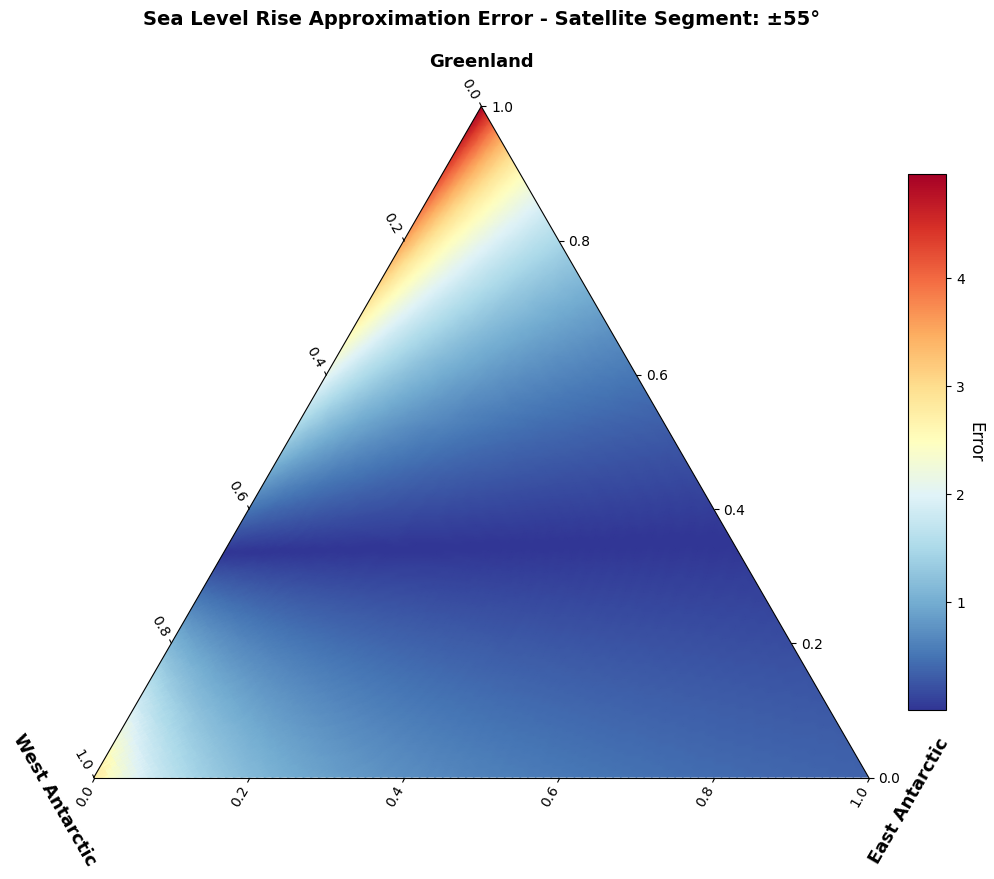

In [6]:
fig = plot_ternary_heatmap(
    error_output,
    55,
    [
        "greenland_contribution",
        "west_antarctic_contribution",
        "east_antarctic_contribution",
    ],
    ["Greenland", "West Antarctic", "East Antarctic"],
)
plt.show()
# fig.savefig("ternary_heatmap_segment_40.png")

Max error across all segments: 7.49; Min error across all segments: 0.00


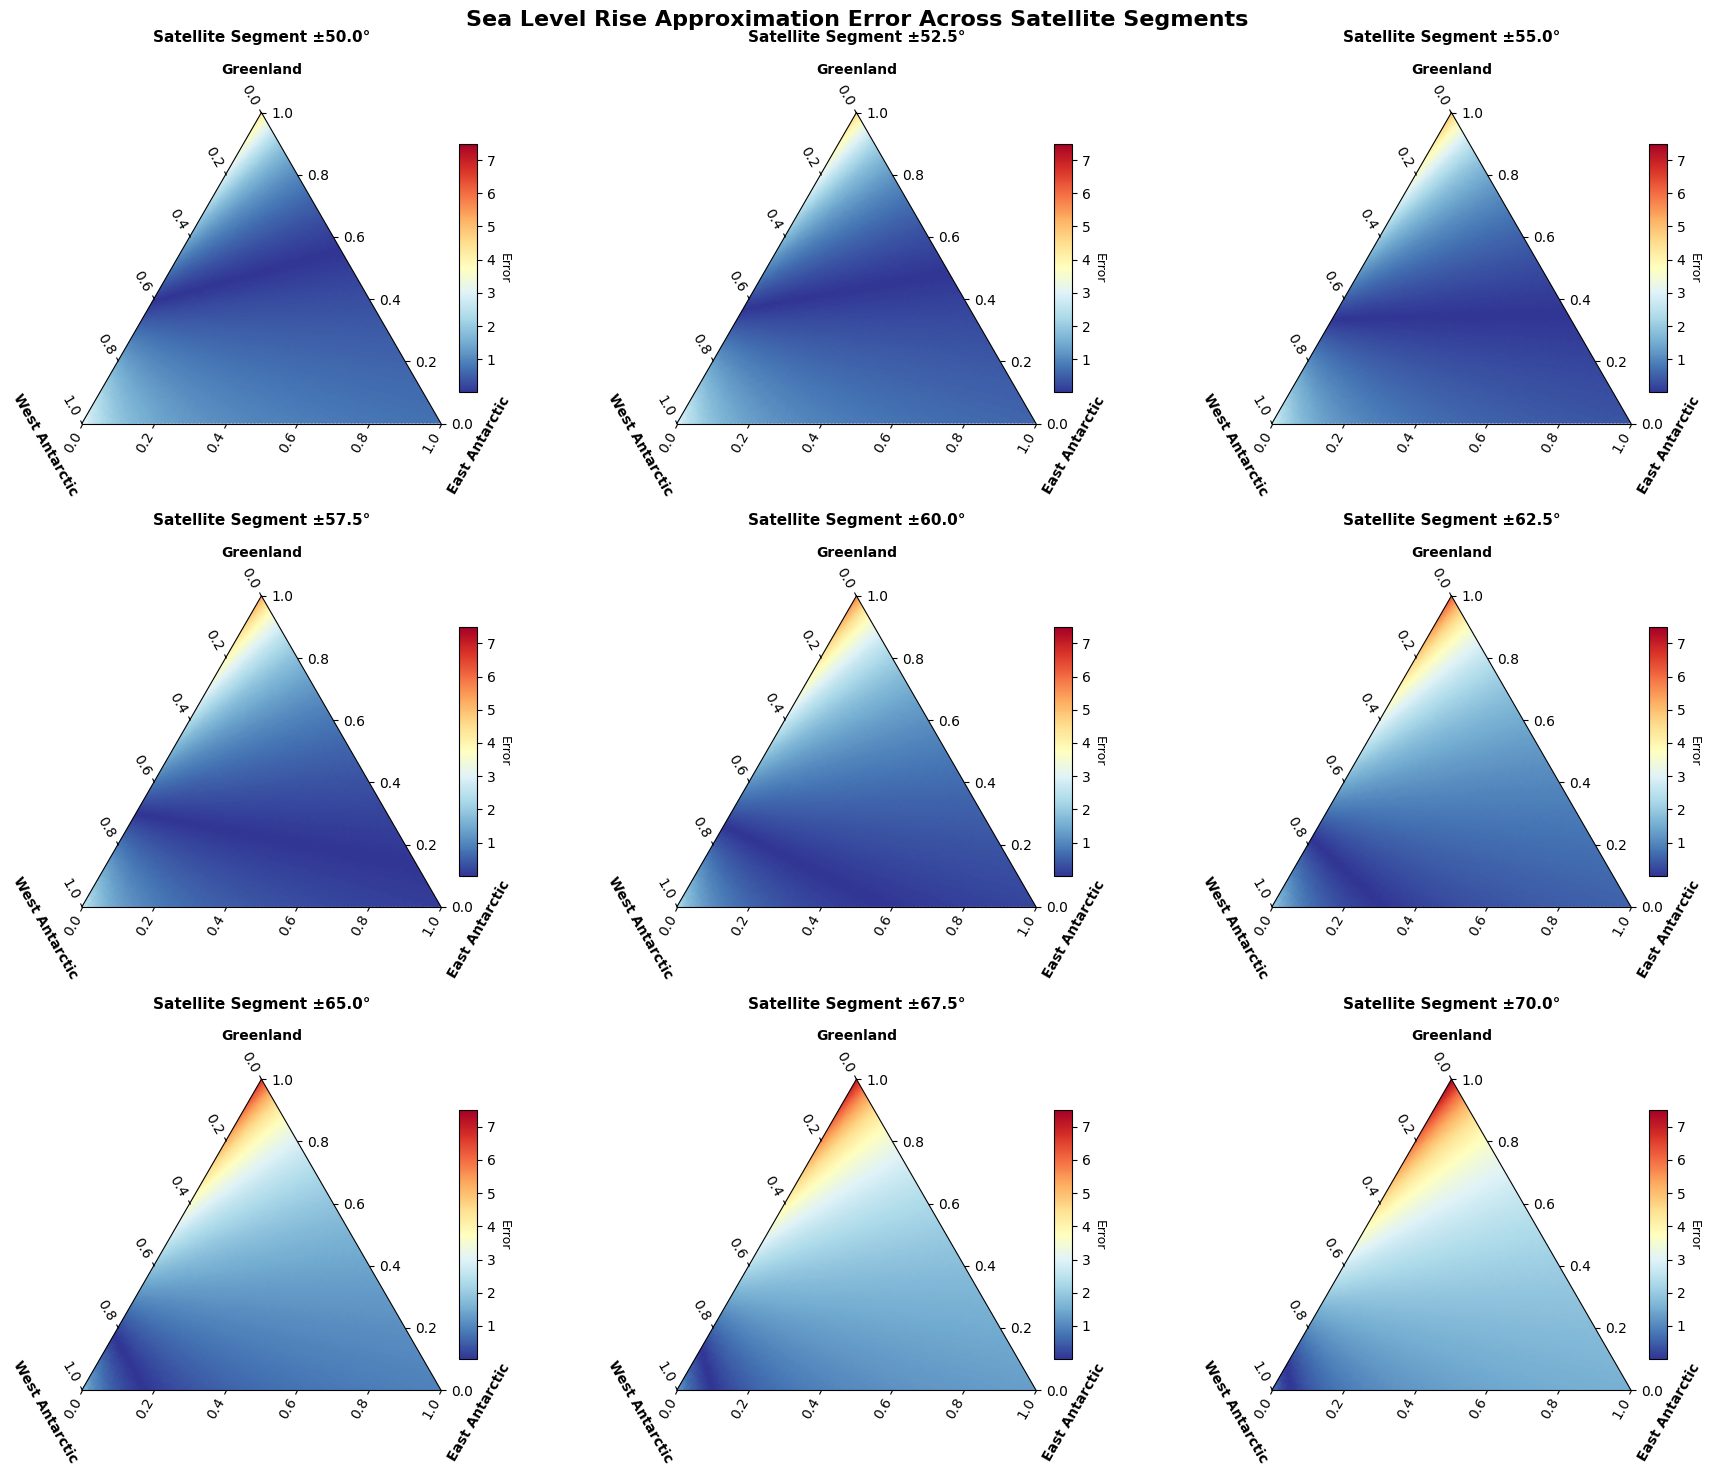

In [7]:
# make subplots for segments 10, 20, 30, 40, 50, 60, 70, 80, 90 with shared color scale

fig, print_statement = plot_ternary_heatmap_subplots(
    error_output,
    segment_list=sat_data_range,
    sources=[
        "greenland_contribution",
        "west_antarctic_contribution",
        "east_antarctic_contribution",
    ],
    labels=["Greenland", "West Antarctic", "East Antarctic"],
    ncols=3,
    uniform_color_scale=True,
)

print(print_statement)
plt.show()

Max error across all segments: 7.49; Min error across all segments: 0.00


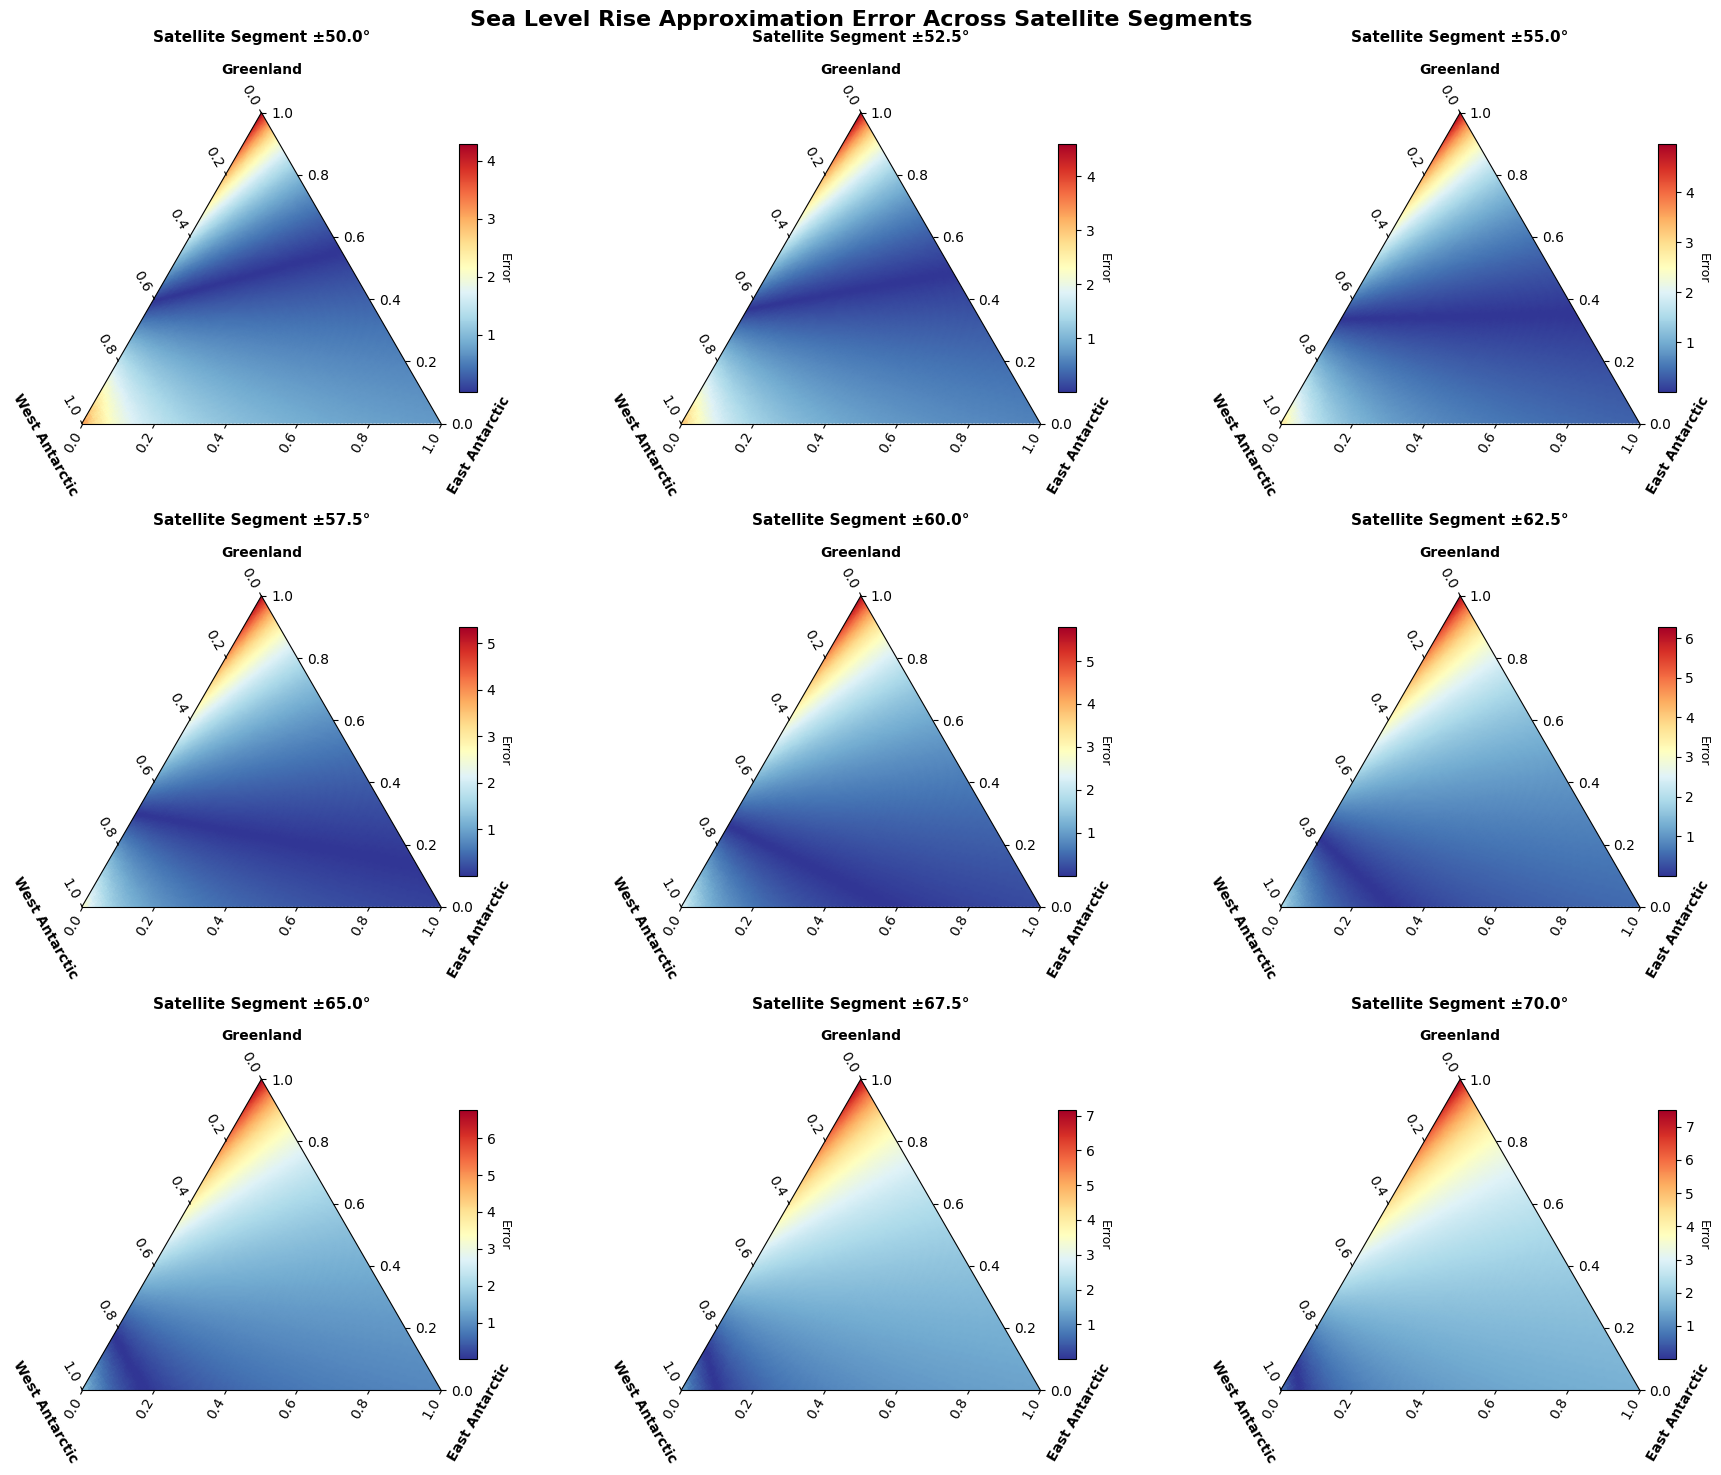

In [8]:
# make subplots for segments 10, 20, 30, 40, 50, 60, 70, 80, 90 with unique color scale

fig, print_statement = plot_ternary_heatmap_subplots(
    error_output,
    segment_list=sat_data_range,
    sources=[
        "greenland_contribution",
        "west_antarctic_contribution",
        "east_antarctic_contribution",
    ],
    labels=["Greenland", "West Antarctic", "East Antarctic"],
    ncols=3,
    uniform_color_scale=False,
)

print(print_statement)
plt.show()

## Error distribution

Plotting the error distribution across different segments

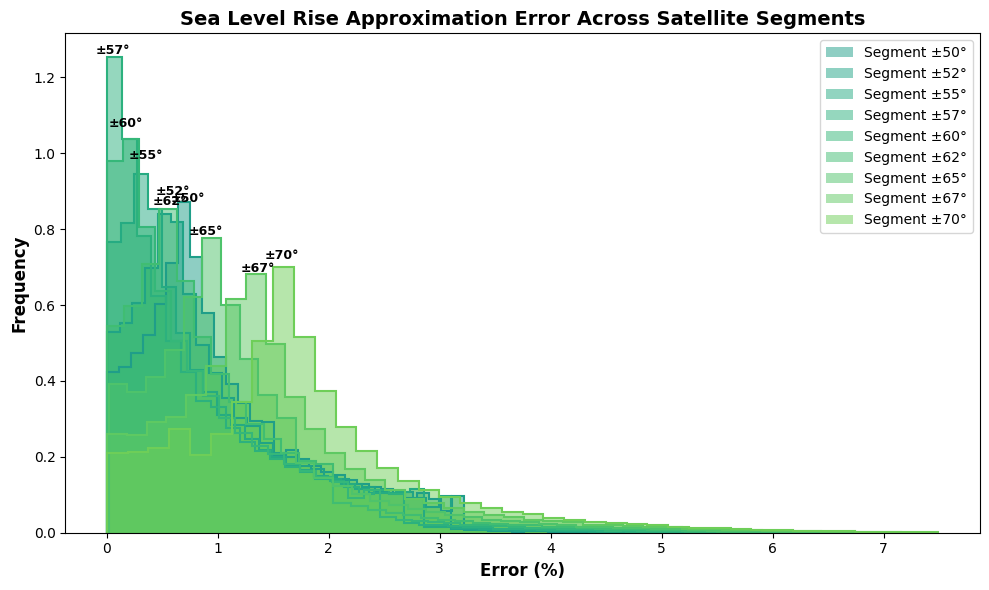

In [9]:
# plot the error vs frequency histogram for each segment on one axis
bins = 40
density = True
cmap = plt.get_cmap("viridis")


fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
for segment in np.unique(error_output["segment"]):
    segment_data = error_output[error_output["segment"] == segment]
    ax.hist(
        segment_data["error"],
        bins=bins,
        alpha=0.5,
        label=f"Segment ±{int(segment)}°",
        density=density,
        # use Perceptually Uniform Sequential colormap
        color=cmap(segment / 90),
        align="mid",
    )
# add a opaque line around each histogram for visibility
for segment in np.unique(error_output["segment"]):
    segment_data = error_output[error_output["segment"] == segment]
    ax.hist(
        segment_data["error"],
        bins=bins,
        density=density,
        # use Perceptually Uniform Sequential colormap
        color=cmap(segment / 90),
        align="mid",
        histtype="step",
        linewidth=1.5,
    )
ax.set_xlabel("Error (%)", fontsize=12, fontweight="bold")
ax.set_ylabel("Frequency", fontsize=12, fontweight="bold")
ax.set_title(
    "Sea Level Rise Approximation Error Across Satellite Segments",
    fontsize=14,
    fontweight="bold",
)
# label the peak of each histogram with its segment
for segment in np.unique(error_output["segment"]):
    segment_data = error_output[error_output["segment"] == segment]
    counts, bin_edges = np.histogram(segment_data["error"], bins=50, density=True)
    max_count_index = np.argmax(counts)
    peak_error = (bin_edges[max_count_index] + bin_edges[max_count_index + 1]) / 2
    ax.text(
        peak_error,
        counts[max_count_index],
        f"±{int(segment)}°",
        fontsize=9,
        fontweight="bold",
        ha="center",
        va="bottom",
    )
ax.legend()
plt.tight_layout()
plt.show()